In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime


In [52]:
data_dir = r'C:\Users\elbai\PycharmProjects\West_Coast_Regional_Datathon_2020\data'

In [53]:
tag_threshold = 500

In [54]:
from datetime import datetime
dt_parser = lambda x: datetime.utcfromtimestamp(int(x)).strftime("%d/%m/%Y %H:%M:%S")

tag_df = pd.read_csv(data_dir + '/movie_lense/tags.csv', parse_dates=['timestamp'],  date_parser=dt_parser)
tag_df.head(10)
tag_df.describe()

,userId,movieId
count,1.108997e+06,1.108997e+06
mean,1.248016e+05,5.492109e+04
std,7.726964e+04,5.618123e+04
min,1.400000e+01,1.000000e+00
25%,7.340600e+04,3.362000e+03
50%,1.030130e+05,4.374400e+04
75%,1.883600e+05,9.682100e+04
max,2.832210e+05,1.938680e+05


In [55]:
print(tag_df.head(10))
tag_df = tag_df.groupby('tag').filter(lambda x: len(x) > tag_threshold)
tag_count = tag_df['tag'].value_counts()
print(tag_count)

   userId  movieId             tag           timestamp
0      14      110            epic 2015-09-25 02:35:38
1      14      110        Medieval 2015-09-25 02:35:32
2      14      260          sci-fi 2015-09-13 18:36:50
3      14      260    space action 2015-09-13 18:37:01
4      14      318    imdb top 250 2015-09-18 22:26:35
5      14      318         justice 2015-09-18 22:26:32
6      14      480       Dinosaurs 2015-09-25 02:36:03
7      14      593  psychothriller 2015-05-10 03:04:46
8      14     1682      philosophy 2015-09-18 22:25:58
9      14     1682    surveillance 2015-09-18 22:26:07
sci-fi         9400
atmospheric    6430
action         6219
comedy         5923
surreal        5299
               ... 
intelligent    1008
futuristic     1008
racism         1004
Brad Pitt      1003
military       1001
Name: tag, Length: 137, dtype: int64


In [153]:
#changed to tuple
ntag_df = tag_df.groupby('movieId').agg(lambda x: x.tolist()).drop(['userId', 'timestamp'],axis=1)
# tag_count = tag_df['tag'].value_counts()
ntag_df

,tag
movieId,
1,"[comedy, family, friendship, adventure, animat..."
2,"[fantasy, adapted from:book, based on a book, ..."
3,"[sequel, comedy, sequel, funny, CLV]"
4,"[based on novel or book, revenge, CLV]"
5,"[remake, family, sequel, family, humorous, CLV..."
...,...
193679,[drama]
193731,[based on a book]
193837,"[aliens, anime]"


In [98]:
tagged_movies = pd.get_dummies(tag_df[['movieId', 'tag']], prefix='tag', columns=['tag']).groupby('movieId').max()

#tagged_movies = pd.get_dummies(tag_df[['movieId', 'tag']], columns=['tag']).groupby('movieId').max()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28921 entries, 1 to 193868
Columns: 137 entries, tag_Action to tag_zombies
dtypes: uint8(137)
memory usage: 4.0 MB


In [121]:
tagged_movies['rating_total'] = 0
tagged_movies['rating_count'] = 0
i = 0
for df in pd.read_csv(data_dir + '/movie_lense/ratings.csv',  date_parser=dt_parser, chunksize=1000):
    df.drop(['userId', 'timestamp'], axis=1, inplace=True)
    new_ratings = df.groupby('movieId').agg(['sum', 'count']).head(10)
    new_ratings.columns = ["_partial_".join(x) for x in new_ratings.columns.ravel()]
    new_ratings = pd.concat([tagged_movies[['rating_total', 'rating_count']], new_ratings], axis=1).fillna(0)
    tagged_movies.rating_total = tagged_movies.rating_total.add(new_ratings['rating_partial_sum'])
    tagged_movies.rating_count = tagged_movies.rating_count.add(new_ratings['rating_partial_count'])

print(tagged_movies)

         tag_Action  tag_BD-R  tag_Betamax  tag_Brad Pitt  tag_CLV  \
movieId                                                              
1                 0         0            0              0        1   
2                 0         0            0              0        1   
3                 0         0            0              0        1   
4                 0         0            0              0        1   
5                 0         0            0              0        1   
...             ...       ...          ...            ...      ...   
193679            0         0            0              0        0   
193731            0         0            0              0        0   
193837            0         0            0              0        0   
193864            0         0            0              0        0   
193868            0         0            0              0        0   

         tag_Criterion  tag_Disney  tag_Johnny Depp  tag_Leonardo DiCaprio  \
movieId    

In [132]:
#tagged_movies.to_pickle('./tagged_movies.pkl')
tagged_movies = tagged_movies[tagged_movies['rating_count'] > 0]
tagged_movies['rating_avg'] = tagged_movies.apply(lambda x: x.rating_total/x.rating_count, axis=1)
#tagged_movies.to_pickle('./tagged_movies_w_rating_avg2.pkl')

<ipython-input-132-cb5f44f99e9e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tagged_movies['rating_avg'] = tagged_movies.apply(lambda x: x.rating_total/x.rating_count, axis=1)


In [ ]:
from sklearn import naive_bayes
from sklearn.model_selection import train_test_split
tagged_movies = pd.read_pickle('tagged_movies_w_rating_avg.pkl')
input_df = tagged_movies.drop(columns=['rating_total', 'rating_count', 'rating_avg'])
rating_avg = tagged_movies.rating_avg
[lower, upper] = rating_avg.quantile([0.3, 0.7])
def rating_to_sentiment(rating):
    if rating < lower:
        sentiment = -1
    elif rating > upper:
        sentiment = 1
    else:
        sentiment = 0
    return sentiment
output_df = rating_avg.apply(lambda x: rating_to_sentiment(x))
X_train, X_test, y_train, y_test = train_test_split(input_df, output_df, test_size=0.5, random_state=0)
gnb = naive_bayes.GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))

c:\users\elbai\appdata\local\programs\python\python38-32\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


0.3    2.8
0.7    3.5
Name: rating_avg, dtype: float64
count    4621.000000
mean        3.115317
std         0.870598
min         0.500000
25%         2.541667
50%         3.166667
75%         3.681818
max         5.000000
Name: rating_avg, dtype: float64


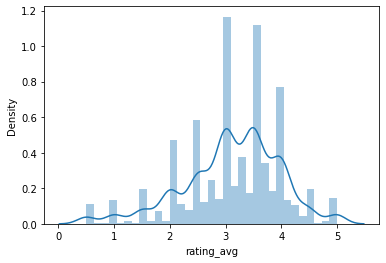

In [149]:
sns.distplot(rating_avg)
print(rating_avg.quantile([0.3, 0.7]))
print(rating_avg.describe())